# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. 

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "testing"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epochs = 200

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

2022-10-13 23:02:46.544839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 15x25 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [4]:
Input_dir='../data/raw_images/labelled_bmp_data_equal_combined_final'

files = glob.glob(Input_dir + '/*.bmp')
x_data = []
y_data = []

for file in files:
    base = os.path.basename(file)
    target = base[0:1]
    category = int(target)
    test_image = Image.open(file)
    test_image = np.array(test_image, dtype="int8")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 10)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(8279, 25, 15, 3)
(8279, 10)


In [5]:
len(x_data)

8279

In [6]:
len(X_train)

6623

### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 10
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [17]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(25,15,3)),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Flatten(),
#         tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])


In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 25, 15, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 8, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 8, 16)         4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 4, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 4, 16)          2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 2, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics = ["accuracy"])

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [24]:
Batch_Size = 64
Shift_Range = 1
Brightness_Range = 0.1
Rotation_Angle = 0
ZoomRange = 0.0
# Epochs = 10

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle,vertical_flip=True)

# datagen = ImageDataGenerator(featurewise_center=False,
#                                  featurewise_std_normalization=False,
#                                  rotation_range=20,
#                                  width_shift_range=0.2,
#                                  height_shift_range=0.2,
#                                  vertical_flip=True)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epochs)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epochs)



Epoch 1/200
130/130 [==============================] - 4s 34ms/step - loss: 0.4212 - accuracy: 0.8680 - val_loss: 0.4103 - val_accuracy: 0.8792
Epoch 2/200
130/130 [==============================] - 4s 34ms/step - loss: 0.4113 - accuracy: 0.8738 - val_loss: 0.3980 - val_accuracy: 0.8835
Epoch 3/200
130/130 [==============================] - 4s 34ms/step - loss: 0.4014 - accuracy: 0.8746 - val_loss: 0.3856 - val_accuracy: 0.8786
Epoch 4/200
130/130 [==============================] - 4s 35ms/step - loss: 0.3762 - accuracy: 0.8850 - val_loss: 0.3887 - val_accuracy: 0.8865
Epoch 5/200
130/130 [==============================] - 5s 35ms/step - loss: 0.3789 - accuracy: 0.8826 - val_loss: 0.3519 - val_accuracy: 0.8998
Epoch 6/200
130/130 [==============================] - 4s 35ms/step - loss: 0.3717 - accuracy: 0.8902 - val_loss: 0.3643 - val_accuracy: 0.8955
Epoch 7/200
130/130 [==============================] - 5s 35ms/step - loss: 0.3577 - accuracy: 0.8888 - val_loss: 0.3740 - val_accuracy:

130/130 [==============================] - 5s 37ms/step - loss: 0.1088 - accuracy: 0.9714 - val_loss: 0.1251 - val_accuracy: 0.9722
Epoch 58/200
130/130 [==============================] - 5s 38ms/step - loss: 0.1081 - accuracy: 0.9739 - val_loss: 0.0985 - val_accuracy: 0.9819
Epoch 59/200
130/130 [==============================] - 5s 37ms/step - loss: 0.1037 - accuracy: 0.9735 - val_loss: 0.1095 - val_accuracy: 0.9764
Epoch 60/200
130/130 [==============================] - 5s 38ms/step - loss: 0.0989 - accuracy: 0.9762 - val_loss: 0.1138 - val_accuracy: 0.9716
Epoch 61/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0968 - accuracy: 0.9778 - val_loss: 0.1146 - val_accuracy: 0.9704
Epoch 62/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0996 - accuracy: 0.9735 - val_loss: 0.1052 - val_accuracy: 0.9734
Epoch 63/200
130/130 [==============================] - 4s 34ms/step - loss: 0.1013 - accuracy: 0.9760 - val_loss: 0.0868 - val_accuracy: 0.981

130/130 [==============================] - 5s 35ms/step - loss: 0.0416 - accuracy: 0.9896 - val_loss: 0.0321 - val_accuracy: 0.9915
Epoch 114/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0412 - accuracy: 0.9911 - val_loss: 0.0362 - val_accuracy: 0.9915
Epoch 115/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0415 - accuracy: 0.9913 - val_loss: 0.0351 - val_accuracy: 0.9934
Epoch 116/200
130/130 [==============================] - 5s 36ms/step - loss: 0.0357 - accuracy: 0.9931 - val_loss: 0.0345 - val_accuracy: 0.9940
Epoch 117/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0380 - accuracy: 0.9924 - val_loss: 0.0347 - val_accuracy: 0.9940
Epoch 118/200
130/130 [==============================] - 5s 36ms/step - loss: 0.0377 - accuracy: 0.9911 - val_loss: 0.0397 - val_accuracy: 0.9928
Epoch 119/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0348 - accuracy: 0.9926 - val_loss: 0.0426 - val_accuracy:

130/130 [==============================] - 5s 38ms/step - loss: 0.0176 - accuracy: 0.9965 - val_loss: 0.0289 - val_accuracy: 0.9946
Epoch 170/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 0.0244 - val_accuracy: 0.9946
Epoch 171/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0200 - accuracy: 0.9947 - val_loss: 0.0291 - val_accuracy: 0.9909
Epoch 172/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0155 - accuracy: 0.9976 - val_loss: 0.0177 - val_accuracy: 0.9964
Epoch 173/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0168 - accuracy: 0.9971 - val_loss: 0.0177 - val_accuracy: 0.9970
Epoch 174/200
130/130 [==============================] - 5s 37ms/step - loss: 0.0145 - accuracy: 0.9972 - val_loss: 0.0136 - val_accuracy: 0.9958
Epoch 175/200
130/130 [==============================] - 5s 35ms/step - loss: 0.0153 - accuracy: 0.9961 - val_loss: 0.0255 - val_accuracy:

In [30]:
# final_loss, final_acc = model.evaluate(X_train, y_train)

### Learing result
 
* Visualization of the training and validation results

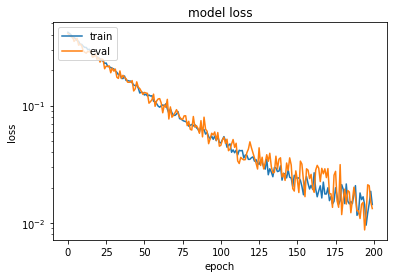

In [27]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [28]:
Input_dir='../data/raw_images/sample'
files = glob.glob(Input_dir + '/*.bmp')

In [29]:
for file in files[:100]: 
    base = os.path.basename(file)
    target = base[0:1]
    image_bmp = Image.open(file)
    test_image = np.array(image_bmp, dtype="float32")
    img = np.reshape(test_image,[1,25,15,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    print(file[:27], classes)
    

../data/raw_images/sample/5 6
../data/raw_images/sample/8 8
../data/raw_images/sample/7 7
../data/raw_images/sample/7 7
../data/raw_images/sample/0 6
../data/raw_images/sample/9 6
../data/raw_images/sample/2 6
../data/raw_images/sample/7 7
../data/raw_images/sample/5 6
../data/raw_images/sample/9 9
../data/raw_images/sample/9 9
../data/raw_images/sample/5 6
../data/raw_images/sample/6 6
../data/raw_images/sample/8 6
../data/raw_images/sample/4 6
../data/raw_images/sample/6 6
../data/raw_images/sample/3 6
../data/raw_images/sample/0 6
../data/raw_images/sample/3 6
../data/raw_images/sample/6 6
../data/raw_images/sample/1 7
../data/raw_images/sample/5 6
../data/raw_images/sample/4 6
../data/raw_images/sample/3 6
../data/raw_images/sample/0 8
../data/raw_images/sample/1 7
../data/raw_images/sample/3 3
../data/raw_images/sample/8 6
../data/raw_images/sample/4 6
../data/raw_images/sample/2 6
../data/raw_images/sample/0 6
../data/raw_images/sample/5 6
../data/raw_images/sample/2 6
../data/ra

### Save the model

* Save the model to the file with the "h5" file format

## Post training weight quantization

* Depending on your requirements (performance, memory and runtime), post training quantization can be done in two ways.

Approach #1:  Post training weight quantization (quantizes weights only) In this case only weights are quantized to int8 but activations remain as they were. Inference input and output are floating-point.

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
# Post training quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("digit_model_quant.tflite", "wb").write(tflite_quant_model)

2022-10-13 23:53:48.077321: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpgg7_66_7/assets


2022-10-13 23:53:48.495790: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-13 23:53:48.495922: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-13 23:53:48.497375: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-10-13 23:53:48.527752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-13 23:53:48.527778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2022-10-13 23:53:48.529934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-10-13 23:53:48.54

16608

In [32]:
def representative_dataset():
    for n in range(1000):
        data = np.expand_dims(x_data[5], axis=0)
        yield [data.astype(np.float32)]

Approach #2: Full integer quantization (Quantizes weights and activations) In this case weights and activations are quantized to int8. First we need to follow the approach #1 to quantize weight and then implement following code to do full integer quantization. This uses quantized input and output, making it compatible with more accelerators, such as the Openmv Camera and Coral Edge TPU. Inference input and output are integers.

In [33]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.dtypes.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()
open("digit_model_quant.tflite_int8.tflite", "wb").write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmp574fg52j/assets


INFO:tensorflow:Assets written to: /tmp/tmp574fg52j/assets
2022-10-13 23:53:57.786799: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-13 23:53:57.786924: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-13 23:53:57.788418: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-13 23:53:57.819546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-13 23:53:57.819573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 9, output_inference_type: 9


15120